In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
from matplotlib.animation import FuncAnimation
plt.rcParams.update({
    'figure.figsize': (4.8, 2.7), 'font.size': 15,
    'lines.linewidth': 2,
    'xtick.labelsize': 'small', 'ytick.labelsize': 'small',
    'axes.spines.top': False, 'axes.spines.right': False,
    'savefig.dpi': 200,
})

import os, pickle
from pathlib import Path
import numpy as np
import torch
from jarvis.utils import tqdm

rng = np.random.default_rng()
FIG_PATH = Path('../figures')

In [2]:
from bisc import rcParams

# comment out the next two lines if 'stimulus' and 'response' already exist in the repository root folder
rcParams['stimulus_path'] = '/mnt/e/BISC_2023/stimulus'
rcParams['response_path'] = '/mnt/e/BISC_2023/response'

In [3]:
from bisc.data import get_session, get_valid_idxs, get_num_channels

session_id = '62529070'
session = get_session(session_id)
num_channels = get_num_channels(session)
trial_idxs, channel_idxs = get_valid_idxs(session)

print('{} valid trials, {} valid channels'.format(len(trial_idxs), len(channel_idxs)))

invalid_mask = np.full((num_channels,), fill_value=True).astype(bool)
invalid_mask[channel_idxs] = False

302 valid trials, 217 valid channels


# PCA of unfiltered response

In [4]:
from bisc.data import get_stim, get_raw_responses

onsets, offsets, stim_params = get_stim(session)

fname = f'../cache/raw.cov_{session_id}.pt'
if not os.path.exists(fname):
    r_sum = np.zeros((num_channels,))
    r_var = np.zeros((num_channels, num_channels))
    count = 0
    for trial_idx in tqdm(trial_idxs, unit='trial'):
        tic, toc = onsets[trial_idx]-800, offsets[trial_idx]+400
        responses = get_raw_responses(session, tic, toc)/1024
        responses[invalid_mask] = 0.
        responses -= responses.mean(axis=1, keepdims=True)
        r_sum += responses.sum(axis=1)
        r_var += np.matmul(responses, responses.T)
        count += responses.shape[1]
    
    r_sum = responses.sum(axis=1)
    r_var = np.matmul(responses, responses.T)
    count = responses.shape[1]
    
    r_cov = r_var/count-np.matmul(r_sum[:, None]/count, r_sum[None]/count)
    torch.save({'r_cov': r_cov}, fname)
else:
    saved = torch.load(fname)
    r_cov = saved['r_cov']

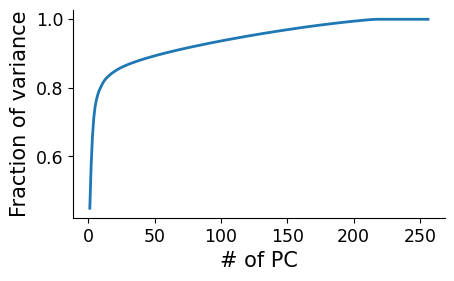

In [5]:
u, s, vh = np.linalg.svd(r_cov)
_, ax = plt.subplots()
ax.plot(np.arange(len(s))+1, np.cumsum(s)/np.sum(s))
ax.set_xlabel('# of PC')
ax.set_ylabel('Fraction of variance')
plt.show()

In [6]:
num_pcs = 96
W = vh[:num_pcs]/(s[:num_pcs, None]**0.5)/100
print('Variance explained {:.2%}'.format(s[:num_pcs].sum()/s.sum()))

Variance explained 93.38%


# Prepare datasets for orientation classification

In [7]:
from bisc.data import get_trial_responses
from torch.utils.data import TensorDataset, DataLoader

def prepare_dsets(session, latency=180., num_bins=36, seed=None, split=0.9, **kwargs):
    assert 36%num_bins==0
    bin_size = int(180/num_bins)
    trial_idxs, channel_idxs = get_valid_idxs(session)
    onsets, offsets, stim_params = get_stim(session)
    rng = np.random.default_rng(seed)
    _idxs = rng.permutation(trial_idxs)
    _size = int(len(trial_idxs)*(1-split)/2)
    idxs = {
        'train': _idxs[_size:-_size],
        'val': _idxs[:_size],
        'test': _idxs[-_size:],
    }
    
    orientations = stim_params['orientations']
    num_gratings = orientations.shape[1]
    grating_duration = (offsets-onsets)[trial_idxs].mean()/num_gratings
    grating_duration = round(grating_duration/5)*5

    spatial_freqs = stim_params['spatial_freqs']
    speeds = stim_params['speeds']
    
    dsets = {}
    for tag in idxs:
        inputs, targets = [], []
        for trial_idx in tqdm(idxs[tag], desc=f'Prepare {tag} set', unit='trial'):
            taus, responses = get_trial_responses(session, trial_idx=trial_idx, **kwargs)
            responses[invalid_mask] = 0.
            for grating_idx in range(num_gratings):
                offset = grating_idx*grating_duration
                inputs.append(responses[:, (taus>=offset)&(taus<offset+latency)])
                
                theta = orientations[trial_idx, grating_idx]
                targets.append(theta)
        dsets[tag] = TensorDataset(
            torch.tensor(np.array(inputs), dtype=torch.float),
            torch.tensor(np.array(targets), dtype=torch.float),
        )
    return dsets

num_bins = 36
latency, dt = 200, 0.5
dsets = prepare_dsets(session, latency, num_bins=num_bins, seed=0, dt=dt, transform={'type': 'remove_mean'})

Prepare train set:   0%|                                                                                      …

Prepare val set:   0%|                                                                                        …

Prepare test set:   0%|                                                                                       …

# 1D Convolutional Neural Network as a classifier

In [8]:
import torch.nn as nn
from torch.nn import MSELoss
from torch.distributions.categorical import Categorical
from jarvis.utils import create_mlp_layers

class ConvDecoder(nn.Module):

    def __init__(self,
        W, num_steps, num_classes, cnn_features=None, mlp_features=None,
        kernel_sizes=11, strides=2,
    ):
        super().__init__()
        if cnn_features is None:
            cnn_features = [32, 64, 128]
        num_layers = len(cnn_features)
        if isinstance(kernel_sizes, int):
            kernel_sizes = [kernel_sizes]*num_layers
        if isinstance(strides, int):
            strides = [strides]*num_layers

        self.W = nn.Parameter(torch.tensor(W, dtype=torch.float), requires_grad=False)
        num_pcs = W.shape[0]

        self.cnn_layers = nn.ModuleList()
        for i in range(num_layers):
            if i==0:
                in_features = num_pcs
            else:
                in_features = cnn_features[i-1]
            out_features = cnn_features[i]
            self.cnn_layers.append(nn.Sequential(
                nn.Conv1d(
                    in_features, out_features,
                    kernel_size=kernel_sizes[i], padding=kernel_sizes[i]//2,
                    stride=strides[i], bias=False,
                ),
                nn.BatchNorm1d(out_features, affine=True),
                nn.ELU(),
            ))
        x = torch.zeros((1, num_pcs, num_steps))
        with torch.no_grad():
            for layer in self.cnn_layers:
                x = layer(x)
        in_features = len(x.flatten())

        self.mlp_layers = create_mlp_layers(in_features, num_classes, mlp_features, nonlinearity='ELU')

    def forward(self, x):
        batch_size, _, t_len = x.shape
        out = torch.matmul(self.W, x.permute(1, 0, 2).reshape(-1, batch_size*t_len)).reshape(-1, batch_size, t_len).permute(1, 0, 2)
        for layer in self.cnn_layers:
            out = layer(out)
        out = out.flatten(1)
        for layer in self.mlp_layers:
            out = layer(out)
        return out

def get_losses(net, inputs, targets, ent_coef, device):
    inputs = inputs.to(device)
    targets = targets.to(device)
    logits = net(inputs)
    num_bins = logits.shape[1]
    targets = torch.floor(targets/180*num_bins).to(torch.long)
    ents = Categorical(logits=logits).entropy()
    losses = torch.nn.CrossEntropyLoss(reduction='none')(logits, targets)-ent_coef*ents
    return losses

def evaluate(net, dset, batch_size=32, device='cuda'):
    net.eval().to(device)
    loader = DataLoader(dset, batch_size)

    loss = 0.
    for inputs, targets in loader:
        with torch.no_grad():
            losses = get_losses(net, inputs, targets, 0., device)
        loss += losses.sum().item()
    loss /= len(dset)
    return loss

def train(net, dset, optimizer, batch_size=32, ent_coef=0.01, device='cuda'):
    net.train().to(device)
    loader = DataLoader(dset, batch_size, shuffle=True, drop_last=True)

    loss = None
    for inputs, targets in loader:
        losses = get_losses(net, inputs, targets, ent_coef, device)
        optimizer.zero_grad()
        losses.mean().backward()
        optimizer.step()
        if loss is None:
            loss = losses.mean().item()
        else:
            loss = 0.9*loss+0.1*losses.mean().item()
    return loss

# Train orientation classifier

In [9]:
num_steps = int(np.floor(latency/dt))
decoder = ConvDecoder(W, num_steps, num_bins, cnn_features=[16, 32, 64]) # orientation

evals = {}
for tag in ['val', 'test']:
    evals[tag] = [evaluate(decoder, dsets[tag])]

optimizer = torch.optim.SGD(decoder.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-2)
num_epochs = 50
min_loss, best_state = float('inf'), None
losses_train = []
with tqdm(total=num_epochs, unit='epoch') as pbar:
    for _ in range(num_epochs):
        losses_train.append(train(decoder, dsets['train'], optimizer, ent_coef=0.))
        for tag in evals:
            evals[tag].append(evaluate(decoder, dsets[tag]))
        loss_test = evals['test'][-1]
        if loss_test<min_loss:
            min_loss = loss_test
            best_state = {k: v.clone() for k, v in decoder.state_dict().items()}
        pbar.set_description('Loss {:.3f}'.format(loss_test))
        pbar.update()
decoder.load_state_dict(best_state)
losses_train = np.array(losses_train)
for tag in evals:
    evals[tag] = np.array(evals[tag])

  0%|                                                                                                         …

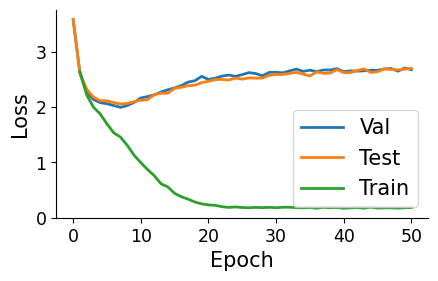

In [10]:
_, ax = plt.subplots()
for tag in ['val', 'test']:
    ax.plot(np.arange(num_epochs+1), evals[tag])
ax.plot(np.arange(num_epochs)+1, losses_train)
# ax.set_ylim([0.05, 0.5])
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(['Val', 'Test', 'Train'])
plt.show()

In [11]:
decoder.eval().cpu()
inputs, targets = dsets['test'][:]
with torch.no_grad():
    logits = decoder(inputs)
    probs = torch.nn.functional.softmax(logits, dim=1)
thetas = ((np.arange(num_bins)+0.5)/num_bins-0.5/36)*2*np.pi
bin_size = 180/num_bins

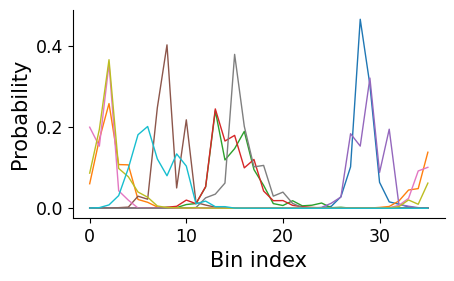

In [12]:
_, ax = plt.subplots()
for _ in range(10):
    ax.plot(rng.choice(probs), linewidth=1)
ax.set_xlabel('Bin index')
ax.set_ylabel('Probability')
plt.show()

In [13]:
density = {}
for i in range(len(probs)):
    theta0 = targets[i].item()/180*2*np.pi
    dthetas = np.round((np.mod(thetas-theta0+np.pi, 2*np.pi)-np.pi)/(2*np.pi)*180/0.5)*0.5
    for j, dtheta in enumerate(thetas-theta0):
        tag = np.round(dtheta/(2*np.pi)*180/0.5)*0.5
        tag = np.mod(tag+90, 180)-90
        if tag in density:
            density[tag].append(probs[i, j].item())
        else:
            density[tag] = [probs[i, j].item()]

thetas = np.array(sorted(density.keys()))
p_mean, p_sem = [], []
for theta in thetas:
    p_mean.append(np.mean(density[theta]))
    p_sem.append(np.std(density[theta])/len(density[theta])**0.5)
p_mean = np.array(p_mean)/bin_size
p_sem = np.array(p_sem)/bin_size

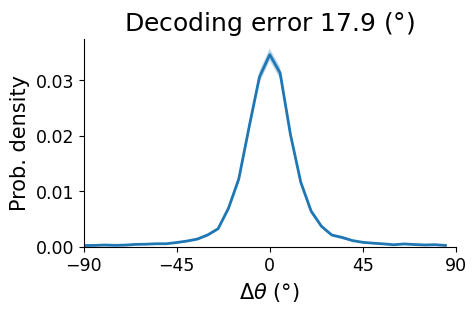

In [14]:
fig, ax = plt.subplots()
ax.plot(thetas, p_mean)
ax.fill_between(thetas, p_mean-p_sem, p_mean+p_sem, alpha=0.3)
ax.set_ylim([0, None])
ax.set_xlim([-90, 90])
ax.set_xlabel(r'$\Delta\theta$ ($\degree$)')
ax.set_ylabel('Prob. density')
ax.set_xticks([-90, -45, 0, 45, 90])
ax.set_title('Decoding error {:.1f}'.format(((thetas**2*p_mean).sum()/p_mean.sum())**0.5)+r' ($\degree$)')
fig.savefig(FIG_PATH/f'Decoding.Error_[{num_bins}bin].svg')

plt.show()

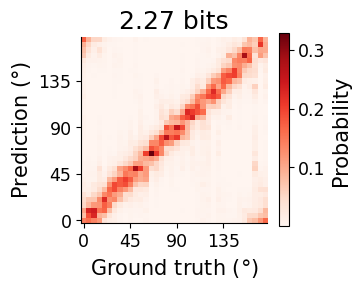

In [15]:
p_mat = np.zeros((36, num_bins))
count = np.zeros((36,))
for i in range(len(targets)):
    theta = targets[i].item()
    k = int(np.floor(theta/5))
    p_mat[k] += probs[i].numpy()
    count[k] += 1
p_mat /= count[:, None]

fig, ax = plt.subplots(figsize=(3, 2.5))
h = ax.imshow(p_mat.T, extent=[-2.5, 180-2.5, -2.5, 180-2.5], origin='lower', cmap='Reds')
ax.set_xticks([0, 45, 90, 135])
ax.set_yticks([0, 45, 90, 135])
ax.set_xlabel(r'Ground truth ($\degree$)')
ax.set_ylabel(r'Prediction ($\degree$)')
ax.set_title('{:.2f} bits'.format(np.log2(num_bins)-(-np.log2(probs)*probs).sum(axis=1).mean().item()))
plt.colorbar(h, label='Probability')
fig.savefig(FIG_PATH/f'orientation.density.matrix_{session_id}_[{num_bins}bin].svg')

plt.show()

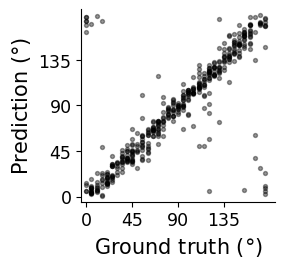

In [16]:
thetas = ((torch.arange(num_bins)+0.5)/num_bins-0.5/36)*2*np.pi
xs = (probs*torch.cos(thetas)).sum(dim=1)
ys = (probs*torch.sin(thetas)).sum(dim=1)

preds = np.mod(np.arctan2(ys, xs).numpy()/(2*np.pi)*180, 180)
gts = np.mod(targets.numpy(), 180)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.scatter(gts, preds, s=8, alpha=0.4, color='k')
ax.set_xlim([-5, 185])
ax.set_xticks([0, 45, 90, 135])
ax.set_xlabel(r'Ground truth ($\degree$)')
ax.set_ylim([-5, 185])
ax.set_yticks([0, 45, 90, 135])
ax.set_ylabel(r'Prediction ($\degree$)')
fig.savefig(FIG_PATH/f'point.prediction_{session_id}_[{num_bins}bin].svg')

plt.show()

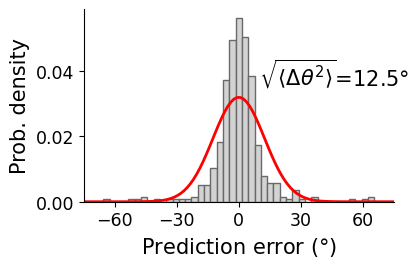

In [17]:
from scipy.stats import norm

dthetas = np.mod(gts-preds+90, 180)-90
theta_mse = (dthetas**2).mean()**0.5

fig, ax = plt.subplots(figsize=(4, 2.5))
ax.hist(dthetas, np.linspace(-90, 90, 60), density=True, facecolor='lightgray', edgecolor='dimgray')
xs = np.linspace(-90, 90, 120)
pdf = norm.pdf(xs, scale=theta_mse)
ax.plot(xs, pdf, color='red')
# ax.set_title('Decoding error {:.1f} ($\degree$)'.format((dthetas**2).mean()**0.5))
ax.set_xlabel('Prediction error ($\degree$)')
ax.set_ylabel('Prob. density')
ax.set_xlim([-75, 75])
ax.set_xticks([-60, -30, 0, 30, 60])
ymax = ax.get_ylim()[1]
# ax.text(-60, ymax*0.6, r'$\sigma_\theta$={:.1f}$\degree$'.format(theta_mse))
ax.text(10, ymax*0.6, r'$\sqrt{ \langle \Delta\theta^2 \rangle}$'+'={:.1f}'.format(theta_mse)+r'$\degree$')
fig.savefig(FIG_PATH/f'decoding.error_{session_id}_[{num_bins}bin].svg')

plt.show()